In [1]:
import itertools

import collections
import random

import sklearn.pipeline, sklearn.impute, sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.feature_selection

import numpy as np
import pandas as pd
import pymatgen.symmetry.analyzer
from pymatgen.analysis.local_env import JmolNN
import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tqdm.tqdm.pandas()

In [3]:
dataset_path = "../data_splitting/all_descriptors.pkl"
df = pd.read_pickle(dataset_path)

# Spacegroup Binning

In [4]:
df["spacegroup_number"] = df["ox_struct"].apply(lambda struct: pymatgen.symmetry.analyzer.SpacegroupAnalyzer(struct).get_space_group_number())

Text(0, 0.5, 'Cumulative Count (%)')

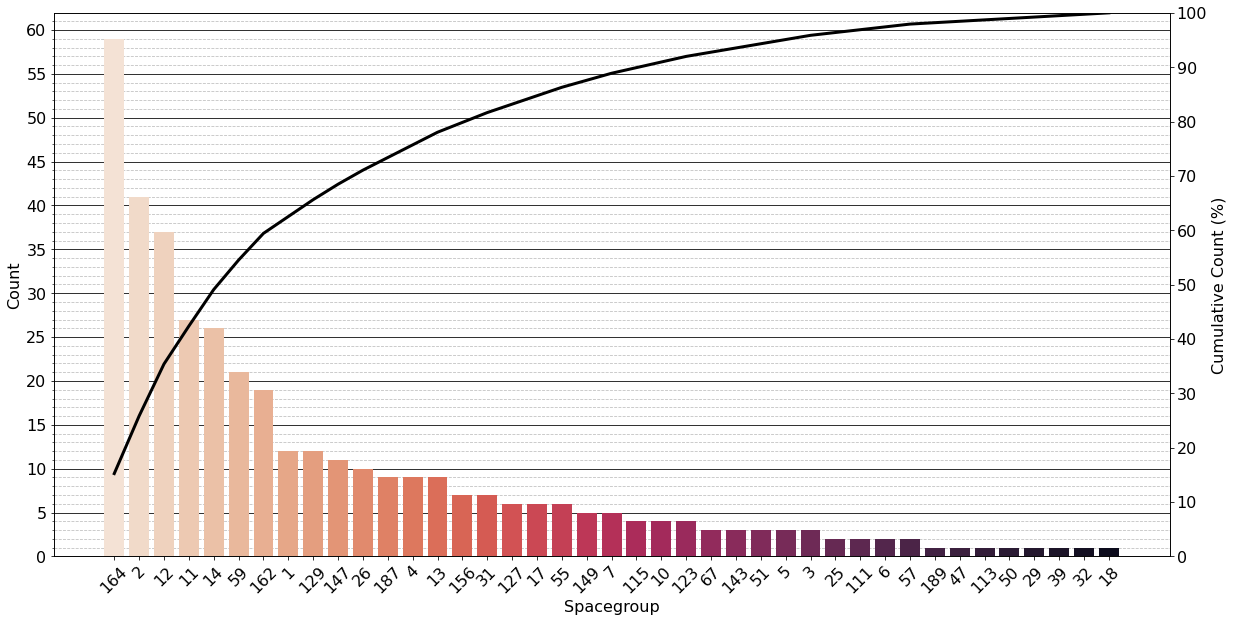

In [5]:
counts = collections.Counter(df["spacegroup_number"])
sorted_counts = list(sorted(zip(map(str, counts.keys()), counts.values()), key=lambda i: -i[1]))
counts_x = [i[0] for i in sorted_counts]
counts_y = [i[1] for i in sorted_counts]

plt.rcParams["figure.figsize"] = [20,10]
plt.rcParams["font.size"] = 16
plt.xticks(rotation=45)

# Barplot
sns.barplot(x=counts_x, y=counts_y, palette=sns.color_palette('rocket_r', n_colors=len(counts_x)))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.gca().yaxis.grid(which='major', color="black")
plt.gca().yaxis.grid(which='minor', color="black", alpha=0.25, linestyle='--')
plt.gca().set_axisbelow(True)
plt.xlabel("Spacegroup")
plt.ylabel("Count")

# Probabilities
counts_cumulative = []
total = 0
for count in counts_y:
    total += count
    counts_cumulative.append(total)
counts_cumulative = list(map(lambda i: 100 * i / counts_cumulative[-1], counts_cumulative))

ax2 = plt.twinx()
ax2.plot(counts_cumulative, c='black', lw=3)
ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
ax2.set_ylim([0,100])
ax2.set_ylabel("Cumulative Count (%)")

20


Text(0, 0.5, 'Cumulative Count (%)')

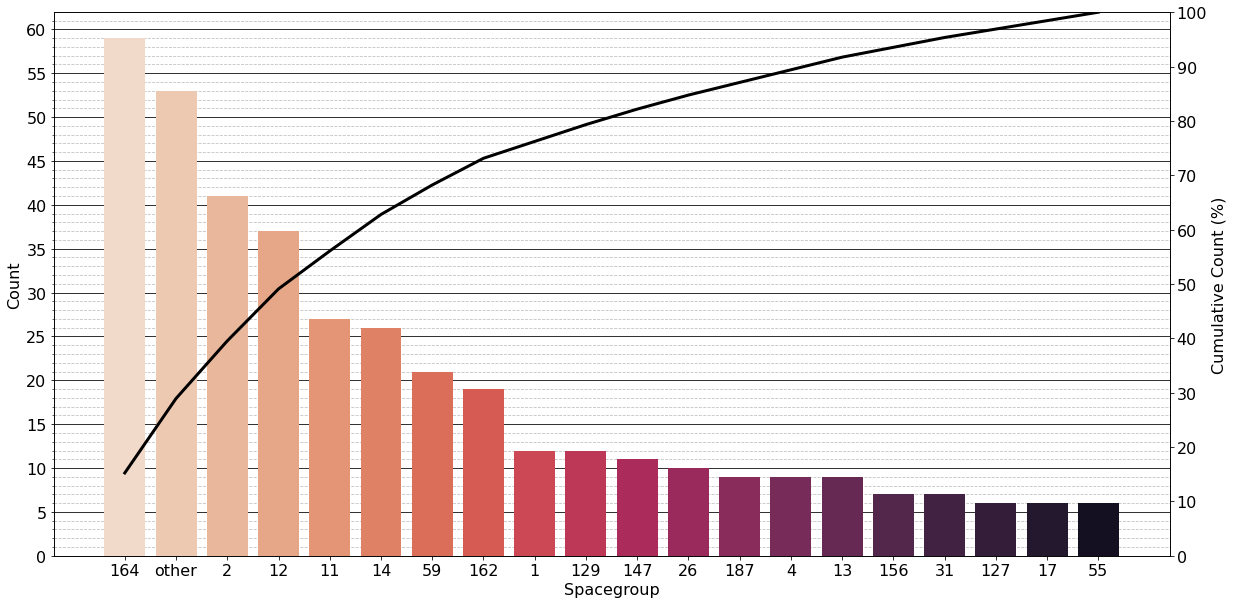

In [6]:
counts = collections.Counter(df["spacegroup_number"])
sorted_counts = list(sorted(zip(map(str, counts.keys()), counts.values()), key=lambda i: -i[1]))

binned_counts = {"other": 0}
for spacegroup, count in sorted_counts:
    if count > 5:
        binned_counts[spacegroup] = count
    else:
        binned_counts["other"] += count

sorted_counts = list(sorted(zip(map(str, binned_counts.keys()), binned_counts.values()), key=lambda i: -i[1]))
counts_x = [i[0] for i in sorted_counts]
print(len(counts_x))
counts_y = [i[1] for i in sorted_counts]

# Barplot
sns.barplot(x=counts_x, y=counts_y, palette=sns.color_palette('rocket_r', n_colors=len(counts_x)))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
plt.gca().yaxis.grid(which='major', color="black")
plt.gca().yaxis.grid(which='minor', color="black", alpha=0.25, linestyle='--')
plt.gca().set_axisbelow(True)
plt.xlabel("Spacegroup")
plt.ylabel("Count")

# Probabilities
counts_cumulative = []
total = 0
for count in counts_y:
    total += count
    counts_cumulative.append(total)
counts_cumulative = list(map(lambda i: 100 * i / counts_cumulative[-1], counts_cumulative))

ax2 = plt.twinx()
ax2.plot(counts_cumulative, c='black', lw=3)
ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
ax2.set_ylim([0,100])
ax2.set_ylabel("Cumulative Count (%)")

In [7]:
df['spacegroup_number'] = df['spacegroup_number'].apply(lambda val: binned_counts.get(str(val), 'other'))

# Additional Structure Featurization

In [8]:
classes = {
'alkaline' : ['H', 'Li', 'Na', 'K', 'Rb', 'Cs', 'Fr'],
'alkaine_earth' : ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra'],
'early_transition' : ['Sc', 'Ti', 'V', 'Cr', 'Mn',
                    'Y', 'Zr', 'Nb', 'Mo', 'Tc',
                    'Hf', 'Ta', 'W', 'Re', 'Os'],
'late_transition' : ['Fe', 'Co', 'Ni', 'Cu', 'Zn',
                   'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
                   'Os', 'Ir', 'Pt', 'Au', 'Hg'],
'triel' : ['B', 'Al', 'Ga', 'In', 'Tl'],
'tetrel' : ['C', 'Si', 'Ge', 'Sn', 'Pb'],
'pnictogen' : ['N', 'P', 'As', 'Sb', 'Bi'],
'chalcogen' : ['O', 'S', 'Se', 'Te', 'Po'],
'halide' : ['F', 'Cl', 'Br', 'I', 'At']
}

groups = {}
for key, values in classes.items():
    for val in values:
        groups[val] = key

In [9]:
symbols_cols = collections.Counter()
bond_cols = collections.Counter()
angle_cols = collections.Counter()

neighbor_finder = JmolNN()

with tqdm.tqdm(total=len(df)) as pbar:
    for struct in df["ox_struct"]:
        symbols_cols.update([groups[symbol] for symbol in struct.symbol_set])
        
        for index, site in enumerate(struct.sites):
            connected = [i['site'] for i in neighbor_finder.get_nn_shell_info(struct, index, 1)]
            
            # Bond counts
            for vertex in connected:
                start, end = sorted([groups[str(site.specie.element)], groups[str(vertex.specie.element)]])
                bond = f"{start}-{end}"
                bond_cols[bond] += 0.5
                
            # Angles
            for angle_start, angle_end in map(sorted, itertools.combinations(connected,2)):
                angle = f"{groups[str(angle_start.specie.element)]}-{groups[str(site.specie.element)]}-{groups[str(angle_end.specie.element)]}"
                angle_cols[angle] += 1
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:48<00:00,  1.70it/s]


In [10]:
tqdm.tqdm.pandas()
all_symbols = set(symbols_cols.keys())
all_bonds = set(bond_cols.keys())
all_angles = set(angle_cols.keys())

def featurize(data):
    symbol_units = "atoms"
    bond_units = "bonds"
    angle_units = "angles"
    struct = data["ox_struct"]
    
    present_symbols = collections.Counter([groups[symbol] for symbol in struct.symbol_set])
    present_bonds = collections.Counter()
    present_angles = collections.Counter()
    
    # Record and Count Symbols
    for symbol, count in present_symbols.items():
        data[f"{symbol} ({symbol_units})"] = count
    data[f"Total Atoms ({symbol_units})"] = sum(present_symbols.values())
    
    for index, site in enumerate(struct.sites):
        connected = [i['site'] for i in neighbor_finder.get_nn_shell_info(struct, index, 1)]
        
        # Count Bonds
        for vertex in connected:
            start, end = sorted([groups[str(site.specie.element)], groups[str(vertex.specie.element)]])
            bond = f"{start}-{end}"
            present_bonds[bond] += 0.5
            
        # Count Angles
        for angle_start, angle_end in map(sorted, itertools.combinations(connected, 2)):
            angle = f"{groups[str(angle_start.specie.element)]}-{groups[str(site.specie.element)]}-{groups[str(angle_end.specie.element)]}"
            present_angles[angle] += 1
            
    # Record Bonds
    for bond, count in present_bonds.items():
        data[f"{bond} ({bond_units})"] = count
    data[f"Total Bonds ({bond_units})"] = sum(present_bonds.values())
            
    # Record Angles
    for angle, count in present_angles.items():
        data[f"{angle} ({angle_units})"] = count
    data[f"Total Angles ({angle_units})"] = sum(present_angles.values())
    
    return data

all_data_features = df.progress_apply(featurize, axis=1)
all_data_features

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:45<00:00,  1.71it/s]


,2dm_id (unitless),Total Angles (angles),Total Atoms (atoms),Total Bonds (bonds),alkaine_earth (atoms),alkaine_earth-chalcogen (bonds),alkaine_earth-chalcogen-alkaine_earth (angles),alkaine_earth-chalcogen-alkaline (angles),alkaine_earth-chalcogen-early_transition (angles),alkaine_earth-chalcogen-halide (angles),...,var:num_unfilled,var:num_valance,var:period,var:sound_velocity,var:specific_heat,var:thermal_conductivity,var:vdw_radius,var:vdw_radius_alvarez,var:vdw_radius_mm3,var:vdw_radius_uff
16,2dm-17,102,2,16.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10.888889,0.222222,0.888889,6.537425e+04,0.222181,116.332089,320.888889,1317.555556,213.555556,2440.675556
19,2dm-20,39,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.836735,1.836735,0.000000,3.309938e+05,0.005760,11250.753474,3.265306,264.489796,90.000000,439.379592
65,2dm-66,0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,2.000000,0.000000,1.910866e+06,0.150850,796.803200,150.222222,410.888889,107.555556,18.402222
75,2dm-76,116,2,24.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000,0.555556,0.138889,1.365261e+04,0.006067,65.975281,133.472222,451.250000,80.000000,1027.222222
84,2dm-86,36,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750000,12.000000,0.000000,3.731840e+05,0.102070,4193.531550,27.000000,300.000000,0.750000,4627.576875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5826,2dm-5837,36,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.687500,15.187500,0.000000,1.118486e+06,0.092640,1196.402700,67.687500,630.750000,0.187500,3057.616875
5909,2dm-5920,126,3,40.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.966942,9.900826,0.330579,1.960219e+05,0.126204,1025.979337,132.925620,390.429752,190.793388,172.486116
5911,2dm-5922,78,3,36.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437500,76.000000,1.687500,4.558714e+05,0.070679,11126.452665,239.359375,727.937500,456.109375,749.968594
5936,2dm-5947,0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Feature Selection

In [11]:
object_cols = ["atoms_object (unitless)",
               "ox_struct"]

regression_irrelevant = object_cols + [
    'discovery_process (unitless)',
    'potcars (unitless)',
    'is_hubbard (unitless)',
    'energy_per_atom (eV)',
    'decomposition_energy (eV/atom)',
    'is_bandgap_direct (unitless)',
    'is_metal (unitless)',
    'energy_vdw_per_atom (eV/atom)',
    'total_magnetization (Bohr Magneton)']

train, test = sklearn.model_selection.train_test_split(all_data_features.drop(columns = regression_irrelevant), test_size=0.1, random_state=RANDOM_SEED)

In [126]:
data_train, data_test = sklearn.model_selection.train_test_split(train.drop(columns=['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)']).fillna(0), 
                                                                 test_size=0.1, random_state=RANDOM_SEED)

train_x = data_train.drop(columns=["bandgap (eV)", 'spacegroup_number']).to_numpy()
train_y = data_train["bandgap (eV)"].to_numpy()

val_x = data_test.drop(columns=["bandgap (eV)", 'spacegroup_number']).to_numpy()
val_y = data_test["bandgap (eV)"].to_numpy()

model = sklearn.pipeline.Pipeline(
    [
     ("Scaler", sklearn.preprocessing.MinMaxScaler()),
     ("Composites", sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True)),
     ("Ensemble", sklearn.ensemble.RandomForestRegressor(n_estimators = 100, max_features=50)
     )]
)

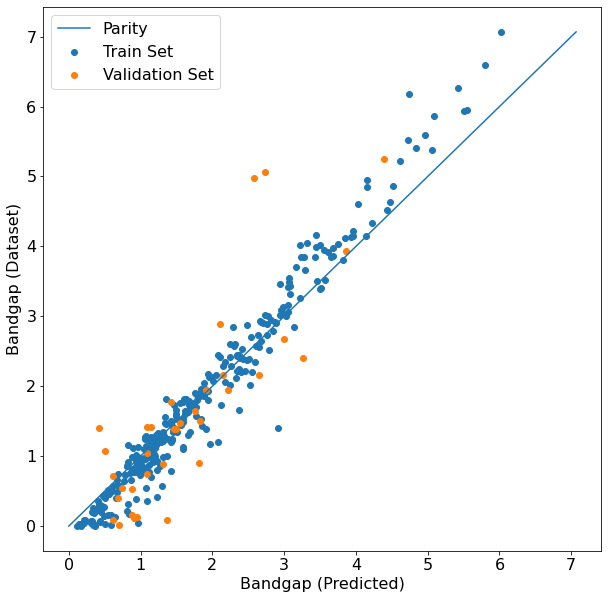

In [127]:
model.fit(X=train_x, y=train_y)

train_y_pred = model.predict(train_x)
val_y_pred = model.predict(val_x)

# Plot the results   
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 16

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=val_y_pred, y=val_y, label="Validation Set")
min_xy = min(min(train_y_pred), min(train_y))
max_xy = max(max(train_y_pred), max(train_y))

plt.plot([min_xy,max_xy], [min_xy,max_xy], label="Parity")
plt.ylabel("Bandgap (Dataset)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()
plt.show()

In [18]:
importances = list(sorted(zip(data_train.drop(columns="bandgap (eV)").columns, model[1].feature_importances_), key=lambda i: -i[1]))
importances

[('ave:density', 0.05064899627347363),
 ('max:heat_capacity_mass', 0.039104658534590386),
 ('min:atomic_weight', 0.03328800776470137),
 ('bond_length_average', 0.01856556123579462),
 ('min:num_valance', 0.018059051099893603),
 ('ave:atomic_number', 0.01800540627464972),
 ('max:density', 0.016510129185587925),
 ('ave:boiling_point', 0.015280296223827086),
 ('ave:gs_energy', 0.015076403742872013),
 ('ave:bulk_modulus', 0.01447569692436353),
 ('max:melting_point', 0.014446181309590793),
 ('var:vdw_radius_alvarez', 0.01210491487710706),
 ('ave:atomic_weight', 0.011905340216939892),
 ('var:atomic_radius', 0.011729178159713945),
 ('min:atomic_number', 0.011594940167583398),
 ('max:bulk_modulus', 0.01104334418658134),
 ('ave:melting_point', 0.010690811144887563),
 ('var:boiling_point', 0.010200493727100517),
 ('ave:heat_of_formation', 0.009998775040998225),
 ('ave:num_d_valence', 0.009817490022343505),
 ('var:gs_bandgap', 0.00963598700211711),
 ('var:en_ghosh', 0.009598480927993805),
 ('min:P

In [19]:
n_features = 25
importances[:n_features]

[('ave:density', 0.05064899627347363),
 ('max:heat_capacity_mass', 0.039104658534590386),
 ('min:atomic_weight', 0.03328800776470137),
 ('bond_length_average', 0.01856556123579462),
 ('min:num_valance', 0.018059051099893603),
 ('ave:atomic_number', 0.01800540627464972),
 ('max:density', 0.016510129185587925),
 ('ave:boiling_point', 0.015280296223827086),
 ('ave:gs_energy', 0.015076403742872013),
 ('ave:bulk_modulus', 0.01447569692436353),
 ('max:melting_point', 0.014446181309590793),
 ('var:vdw_radius_alvarez', 0.01210491487710706),
 ('ave:atomic_weight', 0.011905340216939892),
 ('var:atomic_radius', 0.011729178159713945),
 ('min:atomic_number', 0.011594940167583398),
 ('max:bulk_modulus', 0.01104334418658134),
 ('ave:melting_point', 0.010690811144887563),
 ('var:boiling_point', 0.010200493727100517),
 ('ave:heat_of_formation', 0.009998775040998225),
 ('ave:num_d_valence', 0.009817490022343505),
 ('var:gs_bandgap', 0.00963598700211711),
 ('var:en_ghosh', 0.009598480927993805),
 ('min:P

In [20]:
mutual_information = list(sorted(zip(data_train.drop(columns="bandgap (eV)").columns, sklearn.feature_selection.mutual_info_regression(train_x, train_y)), key=lambda i: -i[1]))
mutual_information

[('max:boiling_point', 0.36435197389733043),
 ('max:bulk_modulus', 0.3543495642044232),
 ('max:melting_point', 0.326074508371613),
 ('min:mendeleev_number', 0.32414577907597986),
 ('min:vdw_radius_uff', 0.31184734463090713),
 ('min:en_ghosh', 0.31046391438400844),
 ('max:evaporation_heat', 0.31000303472184276),
 ('max:vdw_radius_alvarez', 0.3054460132221055),
 ('min:gs_energy', 0.3035731653116067),
 ('min:atomic_weight', 0.2991370643686948),
 ('min:specific_heat', 0.29751987707153793),
 ('var:density', 0.2938966732650665),
 ('var:melting_point', 0.2881083103796622),
 ('max:dipole_polarizability', 0.28715422387839284),
 ('min:icsd_volume', 0.28675821725944806),
 ('min:gs_est_bcc_latcnt', 0.2857835542393845),
 ('min:vdw_radius', 0.28554783157614416),
 ('min:num_valance', 0.2796849374737005),
 ('min:gs_est_fcc_latcnt', 0.27594261553566524),
 ('min:en_allen', 0.2755074252894292),
 ('var:en_pauling', 0.27029198900854023),
 ('var:boiling_point', 0.26637053776845976),
 ('min:Polarizability', 

In [21]:
mutual_information[:n_features]

[('max:boiling_point', 0.36435197389733043),
 ('max:bulk_modulus', 0.3543495642044232),
 ('max:melting_point', 0.326074508371613),
 ('min:mendeleev_number', 0.32414577907597986),
 ('min:vdw_radius_uff', 0.31184734463090713),
 ('min:en_ghosh', 0.31046391438400844),
 ('max:evaporation_heat', 0.31000303472184276),
 ('max:vdw_radius_alvarez', 0.3054460132221055),
 ('min:gs_energy', 0.3035731653116067),
 ('min:atomic_weight', 0.2991370643686948),
 ('min:specific_heat', 0.29751987707153793),
 ('var:density', 0.2938966732650665),
 ('var:melting_point', 0.2881083103796622),
 ('max:dipole_polarizability', 0.28715422387839284),
 ('min:icsd_volume', 0.28675821725944806),
 ('min:gs_est_bcc_latcnt', 0.2857835542393845),
 ('min:vdw_radius', 0.28554783157614416),
 ('min:num_valance', 0.2796849374737005),
 ('min:gs_est_fcc_latcnt', 0.27594261553566524),
 ('min:en_allen', 0.2755074252894292),
 ('var:en_pauling', 0.27029198900854023),
 ('var:boiling_point', 0.26637053776845976),
 ('min:Polarizability', 

In [22]:
importants = set([i[0] for i in importances[:n_features]])
mutual_infos = set([i[0] for i in mutual_information[:n_features]])

set.intersection(importants, mutual_infos)

{'max:bulk_modulus',
 'max:melting_point',
 'min:Polarizability',
 'min:atomic_weight',
 'min:num_valance',
 'var:boiling_point'}

In [35]:
exported_features = [i[0] for i in importances[:n_features]]
print(exported_features)

['ave:density', 'max:heat_capacity_mass', 'min:atomic_weight', 'bond_length_average', 'min:num_valance', 'ave:atomic_number', 'max:density', 'ave:boiling_point', 'ave:gs_energy', 'ave:bulk_modulus', 'max:melting_point', 'var:vdw_radius_alvarez', 'ave:atomic_weight', 'var:atomic_radius', 'min:atomic_number', 'max:bulk_modulus', 'ave:melting_point', 'var:boiling_point', 'ave:heat_of_formation', 'ave:num_d_valence', 'var:gs_bandgap', 'var:en_ghosh', 'min:Polarizability', 'global_instability', 'ave:vdw_radius']


In [82]:
exported_features_units = {
    "ave:density": "mass/length^3",
    "max:heat_capacity_mass": "energy/mass*temperature",
    "min:atomic_weight": "mass",
    "bond_length_average": "length",
    "min:num_valance": "count",
    "ave:atomic_number": "count",
    "max:density": "mass/length^3",
    "ave:boiling_point": "temperature",
    "ave:gs_energy": "energy",
    "ave:bulk_modulus": "force/length^2",
    "max:melting_point": "temperature",
    "var:vdw_radius_alvarez": "length",
    "ave:atomic_weight": "mass",
    "var:atomic_radius": "length",
    "min:atomic_number": "count",
    "max:bulk_modulus": "force/length^2",
    "ave:melting_point": "temperature",
    "var:boiling_point": "temperature",
    "ave:heat_of_formation": "energy/count",
    "ave:num_d_valence": "count",
    "var:gs_bandgap": "energy",
    "var:en_ghosh": "energy",
    "min:Polarizability": "length^3",
    "global_instability": "unitless",
    "ave:vdw_radius": "length",
    "spacegroup_number": "unitless"
}

In [83]:
def add_units(colname):
    if colname not in ["bandgap (eV)"]:
        return f"{colname} ({exported_features_units[colname]})"
    else:
        return colname

In [84]:
train_export = train[['bandgap (eV)', 'spacegroup_number'] + exported_features].fillna(0)
train_export = train_export.rename(add_units, axis=1)
train_export.to_csv('data_train_featurized_importances_bandgap.csv')

In [85]:
test_export = test[['bandgap (eV)', 'spacegroup_number'] + exported_features].fillna(0)
test_export = test_export.rename(add_units, axis=1)
test_export.to_csv('data_test_featurized_importances_bandgap.csv')

# Testing SISSO

In [ ]:
class model:
    def __init__(fun, coefs_dict):
        